<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/PredictStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!pip install ta
!pip uninstall pandas-datareader
!pip install pandas-datareader

Uninstalling pandas-datareader-0.8.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pandas_datareader-0.8.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pandas_datareader/*
Proceed (y/n)? y
  Successfully uninstalled pandas-datareader-0.8.1
  Using cached https://files.pythonhosted.org/packages/14/52/accb990baebe0063977f26e02df36aa7eb4015ed4e86f828cd76273cd6f1/pandas_datareader-0.8.1-py2.py3-none-any.whl


## Import Libraray

In [3]:
#import packages
from IPython.display import display
import pandas as pd
import numpy as np
import bs4 as bs
import requests
import tensorflow as tf

import datetime as dt
import pandas_datareader.data  as pdr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM

from ta.momentum import *
from ta.trend import *
from ta.volume import *
from ta.others import *
from ta.volatility import *
import warnings
warnings.filterwarnings('ignore')

sns.set()
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.2)

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


## Technical Indicator

In [0]:
def MACD(close, fast=12, slow=26, signal=9):
    ma_fast = close.ewm(span=fast, min_periods=fast).mean()
    ma_slow = close.ewm(span=slow, min_periods=slow).mean()
    macd = ma_fast - ma_slow
    ma_signal = macd.ewm(span=signal, min_periods=signal).mean()
    return (macd, ma_signal)

def RSI(close, interval=14):
    """
    Momentum indicator
    As per https://www.investopedia.com/terms/r/rsi.asp
    RSI_1 = 100 - (100/ (1 + (avg gain% / avg loss%) ) )
    RSI_2 = 100 - (100/ (1 + (prev_avg_gain*13+avg gain% / prev_avg_loss*13 + avg loss%) ) )
    E.g. if period==6, first RSI starts from 7th index because difference of first row is NA
    http://cns.bu.edu/~gsc/CN710/fincast/Technical%20_indicators/Relative%20Strength%20Index%20(RSI).htm
    https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
    Verified!
    """
    delta = close - close.shift(1)
    gain = (delta > 0) * delta
    loss = (delta < 0) * -delta
    avg_gain = gain.rolling(interval).sum() / interval
    avg_loss = loss.rolling(interval).sum() / interval
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def IBR(close, low, high):
    return (close - low) / (high - low)

def WilliamR(close, low, high, interval=14):
    """
    Momentum indicator
    Using TA Libraray
    %R = (Highest High - Close)/(Highest High - Lowest Low) * -100
    """
    return wr(high, low, close, interval, fillna=True)

def MFI(close, low, high, vol, interval=14):
    """
    Momentum type indicator
    """
    return money_flow_index(high, low, close, vol, n=interval, fillna=True)

def calculate_roc(series, period):
    return ((series.iloc[-1] - series.iloc[0]) / series.iloc[0]) * 100

def ROC(close, interval=14):
    """
    Momentum oscillator
    As per implement https://www.investopedia.com/terms/p/pricerateofchange.asp
    https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
    ROC = (close_price_n - close_price_(n-1) )/close_price_(n-1) * 100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    # for 12 day period, 13th day price - 1st day price
    return close.rolling(interval + 1).apply(calculate_roc, args=(interval,), raw=False)

def CMF(close, low, high, vol, interval=21):
    """
    An oscillator type indicator & volume type
    No other implementation found
    """
    return chaikin_money_flow(high, low, close, vol, interval, fillna=True)

def calculate_cmo(series, period):
    # num_gains = (series >= 0).sum()
    # num_losses = (series < 0).sum()
    sum_gains = series[series >= 0].sum()
    sum_losses = np.abs(series[series < 0].sum())
    cmo = 100 * ((sum_gains - sum_losses) / (sum_gains + sum_losses))
    return np.round(cmo, 3)

def CMO(close, interval=20):
    """
    Chande Momentum Oscillator
    As per https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
    CMO = 100 * ((Sum(ups) - Sum(downs))/ ( (Sum(ups) + Sum(downs) ) )
    range = +100 to -100
    params: df -> dataframe with financial instrument history
            col_name -> column name for which CMO is to be calculated
            intervals -> list of periods for which to calculated
    return: None (adds the result in a column)
    """
    diff = close.diff()[1:]  # skip na
    return diff.rolling(interval).apply(calculate_cmo, args=(interval,), raw=False)

def SMA(close, interval=9):
    """
    Momentum indicator
    """
    return close.rolling(interval).mean()

def EMA(close, interval=9):
    """
    Momentum indicator
    """
    return close.ewm(span=interval, min_periods=interval-1).mean()

def wavg(rolling_prices, period):
    weights = pd.Series(range(1, period + 1))
    return np.multiply(rolling_prices.values, weights.values).sum() / weights.sum()

def WMA(close, interval=9, hma_step=0):
    """
    Momentum indicator
    """
    return close.rolling(interval).apply(wavg, args=(interval,), raw=False)

def TRIX(close, interval=15):
    """
    Shows the percent rate of change of a triple exponentially smoothed moving average.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:trix
    TA lib actually calculates percent rate of change of a triple exponentially
    smoothed moving average not Triple EMA.
    Momentum indicator
    Need validation!
    """
    return trix(close, interval, fillna=True)

def CCI(close, low, high, interval=20):
    """
    Commodity Channel Index (CCI)
    CCI measures the difference between a security’s price change and its average 
    price change. High positive readings indicate that prices are well above their 
    average, which is a show of strength. Low negative readings indicate that 
    prices are well below their average, which is a show of weakness.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci
    """
    return cci(high, low, close, interval, fillna=True)

def DPO(close, interval=20):
    """
    Detrended Price Oscillator (DPO)
    Is an indicator designed to remove trend from price and make it easier to 
    identify cycles.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:detrended_price_osci    
    """
    return dpo(close, n=interval)

def KST(close, interval=20):
    """
    KST Oscillator (KST Signal)
    It is useful to identify major stock market cycle junctures because its 
    formula is weighed to be more greatly influenced by the longer and more 
    dominant time spans, in order to better reflect the primary swings of stock 
    market cycle.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:know_sure_thing_kst  """
    return kst(close, interval)

def DMI(close, low, high, interval=14):
    """
    Average Directional Movement Index (ADX)
    The Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI) are 
    derived from smoothed averages of these differences, and measure trend direction 
    over time. These two indicators are often referred to collectively as the 
    Directional Movement Indicator (DMI).
    The Average Directional Index (ADX) is in turn derived from the smoothed 
    averages of the difference between +DI and -DI, and measures the strength 
    of the trend (regardless of direction) over time.
    Using these three indicators together, chartists can determine both the 
    direction and strength of the trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx
    """
    return adx(high, low, close, n=interval, fillna=True)

def BB_MAV(close, interval=20):
    """
    Bollinger Bands (BB)
    N-period simple moving average (MA).
    https://en.wikipedia.org/wiki/Bollinger_Bands
    """
    return bollinger_mavg(close, n=interval, fillna=True)

def FI(close, vol, interval=13):
    """
    Force Index (FI)
    It illustrates how strong the actual buying or selling pressure is. 
    High positive values mean there is a strong rising trend, and low 
    values signify a strong downward trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:force_index
    """
    return force_index(close, vol, n=interval, fillna=True)

def EOM(low, high, vol, interval=14):
    """
    An Oscillator type indicator and volume type
    Ease of Movement : https://www.investopedia.com/terms/e/easeofmovement.asp
    """
    dm = (high + low) / 2 - (high.shift(1) - low.shift(1)) / 2
    br = vol / (high - low)
    evm = dm / br
    return evm.rolling(interval).mean()

## Input Data

In [0]:
def load_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.rstrip('\r\n'))
    return tickers


In [0]:
def add_techincal_indicators(input_data):

    close = input_data['close']
    high = input_data['high']
    low = input_data['low']
    vol = input_data['volume']
    adj_close = input_data['adj close']

    input_data = input_data[['open', 'close', 'high', 'low', 'volume']]
    input_data['macd'], input_data['signal'] = MACD(close)
    input_data['rsi'] = RSI(close=close)
    input_data['ibr'] = IBR(close=close, low=low, high=high)
    input_data['willamr'] = WilliamR(close=close, low=low, high=high)
    input_data['mfi'] = MFI(close=close, low=low, high=high, vol=vol)
    input_data['roc'] = ROC(close=close)
    input_data['cmf'] = CMF(close=close, low=low, high=high, vol=vol)
    input_data['cmo'] = CMO(close=close)
    input_data['sma'] = SMA(close=close)
    input_data['ema'] = EMA(close=close)
    input_data['wma'] = WMA(close=close)
    input_data['trix'] = TRIX(close=close)
    input_data['cci'] = CCI(close=close, low=low, high=high)
    input_data['dpo'] = DPO(close=close)
    input_data['kst'] = KST(close=close)
    input_data['dmi'] = DMI(close=close, low=low, high=high)
    input_data['bb'] = BB_MAV(close=close)
    input_data['fi'] = FI(close=close, vol=vol)
    input_data['eom'] = EOM(low=low, high=high, vol=vol)
    input_data.dropna(inplace=True)
    return input_data


In [0]:
def get_input_data(ticker, span=20):
    end_date = dt.date.today()
    start_date = end_date - dt.timedelta(365 * span)
    data = pdr.get_data_yahoo(ticker, start_date, end_date)
    data.columns = map(str.lower, data.columns)
    data = add_techincal_indicators(input_data=data)
    return data


## Build Model

In [0]:
def build_model_data(prices, training_days):
  x_data, y_data = [], []
  for i in range(training_days, len(prices)):
      x_data.append(prices[i - training_days:i, :])
      y_data.append(prices[i, 0:5])
  x_data, y_data = np.array(x_data), np.array(y_data)
  x_data = np.reshape(x_data, (x_data.shape[0], x_data.shape[1], prices.shape[1]))
  return (x_data, y_data)

def build_model(x_train, y_train):

    # create and fit the LSTM network
    model = Sequential()
    model.add(CuDNNLSTM(units=200, 
                    return_sequences=True, 
                    input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(CuDNNLSTM(units=200))
    model.add(Dense(y_train.shape[1]))

    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.summary()

    return model

In [0]:
def train_predict(ticker, training_days=60, span=20, train_ratio=0.7, epochs=30, batch_size=32, verbose=0):
    input_data = get_input_data(ticker, span)
    input_values = input_data.values.reshape(-1, input_data.shape[1])
    input_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = input_scaler.fit_transform(input_values)

    train_size = (int)(len(input_values) * train_ratio)

    #converting dataset into x_train and y_train
    x_train, y_train = build_model_data(scaled_data[:train_size], training_days)
    X_test, _ = build_model_data(scaled_data[train_size - training_days:], training_days)

    # build model with train data
    model = build_model(x_train, y_train)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    result_data = model.predict(X_test)

    # calculate RMSE
    rms = np.sqrt(np.mean(np.power((scaled_data[train_size:, 2] - result_data[:, 1]), 2)))

    result = pd.DataFrame(np.concatenate((scaled_data[train_size:], result_data[:]), axis=1), 
                         columns=np.concatenate((input_data.columns, 
                                                 ["open_pred", "close_pred", 'high_pred', 'low_pred', 'volume_pred'])))
    result['close_last_day'] = result['close'].shift(-1)
    result.dropna(inplace=True)
    result['dir'] = (result['close'] - result['close_last_day']) / result['close_last_day']
    result['dir_pred'] = (result['close_pred'] - result['close_last_day']) / result['close_last_day']

    target_trade = result[(result['dir'] >= 0.01) | (result['dir'] <= -0.01)]
    trading_days = target_trade.shape[1] * 100 / result.shape[0]

    target_trade['accuracy'] = (np.sign(target_trade['dir'] * target_trade['dir_pred']))
    accuracy = target_trade[target_trade['accuracy'] == 1].shape[0] * 100 / target_trade.shape[0]

    print("ticker:{0} RMS:{1:6.3f} Trading_days:{2:6.3f} Accuracy:{3:6.3f}".format(ticker.rjust(4, ' '), rms, trading_days, accuracy))

    return result, accuracy, model, trading_days

In [52]:
result, accuracy, model, trading_days = train_predict('QCOM', verbose=0, epochs=30, training_days=30)

ticker:QCOM RMS: 0.024 Trading_days: 2.203 Accuracy:69.886


In [10]:
tickers = load_sp500_tickers()
results = {}
for ticker in tickers[::25]:
    try:
        results[ticker] = train_predict(ticker, verbose=1)
    except:
        pass


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/30
3436/3436 [==============================] - 3s 816us/step - loss: 0.0026
Epoch 2/30
3436/3436 [==============================] - 1s 368us/step - loss: 8.5231e-04
Epoch 3/30
3436/3436 [==============================] - 1s 364us/step - loss: 8.3970e-04
Epoch 4/30
3436/3436 [==============================] - 1s 369us/step - loss: 8.0327e-04
Epoch 5/30
3436/3436 [==============================] - 1s 362us/step - loss: 7.6815e-04
Epoch 6/30
3436/3436 [==============================] - 1s 363us/step - loss: 7.5024e-04
Epoch 7/30
3436/3436 [==============================] - 1s 370us/step - loss: 7.5012e-04
Epoch 8/30
3436/3436 [==============================] - 1s 368us/step - loss: 7.2265e-04
Epoch 9/30
3436/3436 [==============================] - 1s 370us/step - loss: 7.0379e-04
Epoch 10/30
3436/3436 [==============================] - 1s 366us/step - loss: 6.9427e-04
Epoch 11/30
3436/3436 [========

In [12]:
accuracies = []
tickers = []
trading_days = []
for ticker in results.keys():
    tickers.append(ticker)
    trading_days.append(results[ticker][3])
    accuracies.append(results[ticker][1])
print(np.array(accuracies).mean())
print(np.array(trading_days).mean())

72.51532651760787
4.989969993673952


In [0]:

print("scaled_data:", scaled_data[-1])
print("result_df:")
display(result.tail(1))
orig_data = scalar.inverse_transform(scaled_data)
print("orig_data:", orig_data[-1])
print("input_df:")
display(input_data.tail(1))

next_day_scaled_data = np.concatenate((result.values[-1][-8:-3], np.zeros(scaled_data.shape[1] - 5)))

print("next_day_scaled_data:", next_day_scaled_data)
print("shapes:", next_day_scaled_data.shape, scaled_data.shape)

new_scaled_data = np.vstack((scaled_data, next_day_scaled_data))
print ("new_scaled_data:", new_scaled_data[-2:])

orig_data_with_new = scalar.inverse_transform(new_scaled_data)[:,:5]
print("orig_data:", orig_data_with_new[-2:])

print("new_input_data_df:")
new_input_data = pd.DataFrame(orig_data_with_new, columns=result.columns[0:5])
display(new_input_data.tail(2))

print("new_input_data_df_with_ti:")
new_input_data = add_techincal_indicators(new_input_data)
display(new_input_data.tail(2))

training_days = 60
new_input_values = new_input_data.values.reshape(-1, input_data.shape[1])
new_scaled_data = scalar.transform(new_input_values)
print ("new_scaled_data:", new_scaled_data[-2:])
X_test, _ = build_model_data(new_scaled_data[-training_days - 1:], training_days)
result_data = model.predict(X_test)
print("shape:", result_data.shape)

new_result = pd.DataFrame(np.concatenate((new_scaled_data[-1:], result_data[:]), axis=1), 
                        columns=np.concatenate((new_input_data.columns, 
                                                ["open_pred", "close_pred", 'high_pred', 'low_pred', 'volume_pred'])))

display(new_result)

result.drop(columns=['dir', 'dir_pred', 'accuracy'], inplace=True)
result = pd.concat((result, new_result))
result.reset_index(inplace=True)
result['dir'] = result['close'] - result['close'].shift(1)
result['dir_pred'] = result['close_pred'] - result['close_pred'].shift(1)
result['dir_pred_nday'] = result['dir_pred'].shift(-1)

display(result)

In [106]:
result_tmp = result.copy()
result_tmp['dir'] = result_tmp['close'] - result_tmp['close'].shift(-1)
result_tmp['dir_pred'] = (result_tmp['close_pred'] - result_tmp['close'].shift(-1))

result_tmp['accuracy'] = (np.sign(result_tmp['dir'] * result_tmp['dir_pred']))
accuracy = result_tmp[result_tmp['accuracy'] == 1].shape[0] / result_tmp.shape[0]

print("Accuracy:{0:6.3f}".format( accuracy))


Accuracy: 0.666


In [0]:
# build test data
#test_data = price_scaler.transform(prices[train_size - training_days:])

# predict price using model
result_data = model.predict(X_test)
closing_price = result_data[:, 1]
# calculate RMSE
rms = np.sqrt(np.mean(np.power((scaled_data[train_size:, 2] - closing_price), 2)))
print("RMS:{}".format(rms))

RMS:0.02034100828098295


In [0]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.plot(data['close'], label='Close Price history')
plt.show(sns)

In [0]:
result = pd.DataFrame(np.concatenate((scaled_data[train_size:], result_data[:]), axis=1), 
                         columns=np.concatenate((data.columns, ["open_pred", "close_pred"])))
result['dir'] = result['close'] - result['close'].shift(1)
result['dir_pred'] = (result['close_pred'] - result['close_pred'].shift(1)).shift(-1)
#result.dropna(inplace=True)
display(result)


,open,close,high,low,volume,macd,signal,rsi,ibr,willamr,mfi,roc,cmf,cmo,sma,ema,wma,trix,cci,dpo,kst,dmi,bb,fi,eom,open_pred,close_pred,dir,dir_pred
0,0.819831,0.816029,0.812481,0.834994,0.031916,0.439131,0.430112,0.600954,0.868850,0.757847,0.688161,0.411573,0.647288,0.676607,0.847958,0.848458,0.843056,0.453349,0.551703,0.662052,0.387703,0.013476,0.865487,0.280073,0.292568,0.809088,0.810927,NaN,0.004561
1,0.823794,0.816386,0.815599,0.836460,0.031274,0.441910,0.431042,0.552079,0.586670,0.771302,0.690408,0.405675,0.656941,0.679292,0.848896,0.849451,0.844229,0.453805,0.564157,0.630942,0.388972,0.019937,0.866458,0.280051,0.298685,0.814506,0.815488,0.000357,0.001090
2,0.818029,0.815434,0.814280,0.835482,0.033332,0.443462,0.432136,0.482946,0.611113,0.735427,0.621764,0.399320,0.657212,0.608942,0.849653,0.850043,0.845016,0.454210,0.542072,0.613190,0.389247,0.023580,0.867005,0.279778,0.296850,0.815489,0.816577,-0.000952,-0.003220
3,0.819711,0.809722,0.810803,0.832305,0.027498,0.442153,0.432715,0.409448,0.318841,0.565853,0.548905,0.392474,0.619388,0.573020,0.850003,0.849304,0.844452,0.454138,0.480409,0.629065,0.388623,0.019328,0.867403,0.278743,0.288881,0.811950,0.813357,-0.005712,-0.009073
4,0.813825,0.806628,0.805287,0.825582,0.043891,0.439653,0.432614,0.459505,0.653850,0.443351,0.555677,0.397333,0.622236,0.533964,0.850143,0.848056,0.843167,0.453506,0.397360,0.630545,0.388381,0.019436,0.867618,0.278107,0.273950,0.802203,0.804284,-0.003094,-0.005265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0.801573,0.797227,0.807805,0.817882,0.037403,0.523052,0.500058,0.526607,0.216053,0.780702,0.632391,0.426747,0.445520,0.612825,0.809685,0.807535,0.807333,0.519869,0.595489,0.469210,0.502738,0.160908,0.810715,0.287402,0.793649,0.762985,0.760950,0.014756,0.011098
1495,0.812263,0.796751,0.808165,0.814704,0.031622,0.529409,0.506782,0.543867,0.298430,0.776316,0.645043,0.435889,0.434116,0.602155,0.813592,0.812543,0.811976,0.525459,0.579510,0.582478,0.505883,0.169812,0.814299,0.286175,0.792098,0.773338,0.772048,-0.000476,-0.002132
1496,0.812263,0.817338,0.819195,0.828149,0.035531,0.543076,0.515252,0.633468,0.693642,0.943255,0.710216,0.487950,0.453424,0.671704,0.820006,0.820921,0.820173,0.532023,0.608899,0.524232,0.512223,0.182377,0.820150,0.289428,0.780555,0.771123,0.769917,0.020587,0.020619
1497,0.819350,0.816386,0.821354,0.830349,0.027106,0.551922,0.524027,0.720171,0.543355,0.907278,0.782148,0.526225,0.484827,0.643486,0.827274,0.827421,0.826896,0.538663,0.595604,0.606853,0.516233,0.194900,0.824829,0.287839,0.790184,0.794278,0.790535,-0.000952,-0.000965


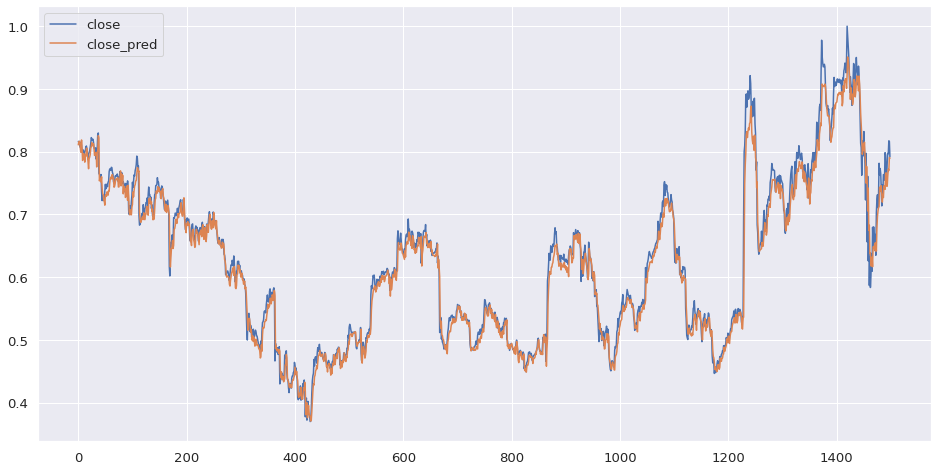

In [0]:
result[['close', 'close_pred']].plot()
plt.show()

In [0]:
result['correct'] = (np.sign(result['dir'] * result['dir_pred']))
print(result[result['correct'] == 1].shape[0] / result.shape[0])

0.8865910607071381


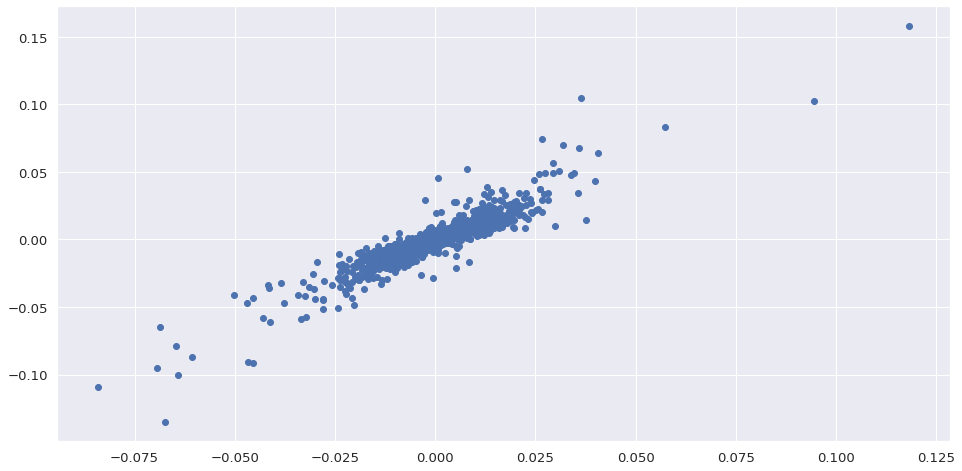

In [0]:
plt.scatter(result['dir_pred'], result['dir'])
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


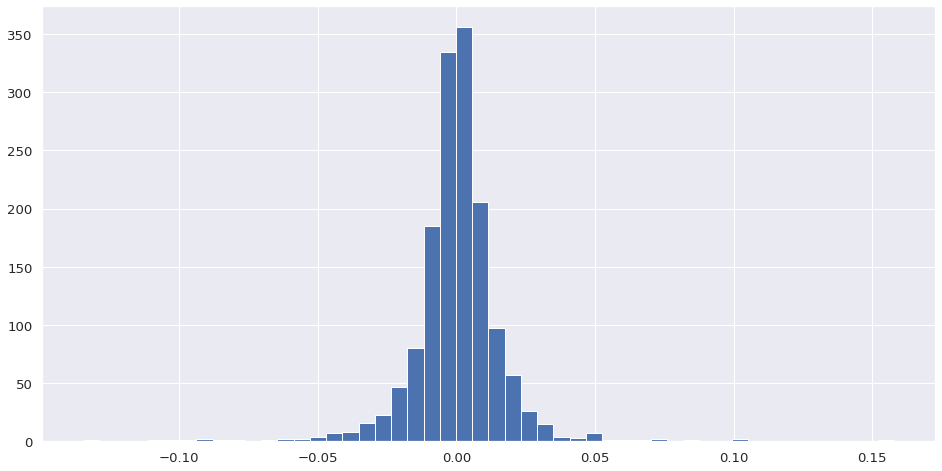

In [0]:
plt.hist(result.dir, bins=50)
plt.show()